# Training VGG16 to Classify ASL Letters

In this notebook we will be training a `keras.applications.VGG16` Convolutional Neural Network (CNN) on the [ASL alphabet images](https://www.kaggle.com/grassknoted/asl-alphabet) preprocessed and organized using [<b><i>split_only_asl.sh</i></b>](https://github.com/angelphanth/alphabet_asl/blob/master/data_augmentation/split_only_asl.sh) and [<b><i>bright_images.py</i></b>](https://github.com/angelphanth/alphabet_asl/blob/master/data_augmentation/bright_images.py). 

**Model Evaluation**

VGG16 model performance when classifying the existing test images will then be evaluated using `sklearn.metrics.classification_report` and `confusion_matrix`. 

Model performance on real-time images will similarly be evaluated in: <b><i>real-time_test.ipynb</i></b>.  

In [8]:
# Importing the usual libraries 
import pandas as pd
import numpy as np

# importing layers
import keras
from keras.layers import Dense, Dropout, Activation
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model, model_from_json, Sequential
from keras.optimizers import Adam
from keras.activations import relu
from keras.utils import plot_model

# Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Why VGG16?
Created by the [Visual Geometry Group (VGG)](https://arxiv.org/abs/1409.1556), VGG16 and VGG19, which we will train in *VGG19_ASL.ipynb* have the [classic CNN architecture](https://towardsdatascience.com/an-intuitive-guide-to-deep-network-architectures-65fdc477db41), defined by 

- a series of convolutional layers to extract the important features, 
- with intermittent max pooling layers to reduce volume size and help prevent over-fitting, and 
- finished off with fully connected layers meant to classify the input based on the extracted features.   

[In 2014 (pre-ResNet)](https://www.pyimagesearch.com/2017/03/20/imagenet-vggnet-resnet-inception-xception-keras/), VGG16 and the deeper VGG19 (three more weight layers)  were considered very deep, which was advantageous because the [classic and most straightforward approach to improving CNN](https://towardsdatascience.com/illustrated-10-cnn-architectures-95d78ace614d) performances was by making them bigger aka deeper. 

However, a drawback to these deeper, archetype CNNs is that their weights end up taking up a lot of storage space, making them harder to deploy. 

-----

Transfer learning was configured using the following Medium articles written by [Parkash Jay](https://medium.com/@14prakash/transfer-learning-using-keras-d804b2e04ef8) and [James Le](https://towardsdatascience.com/the-4-convolutional-neural-network-models-that-can-classify-your-fashion-images-9fe7f3e5399d). 

VGG16 will be trained on 80% of the ASL alphabet images preprocessed using [<b><i>split_only_asl.sh</i></b>](https://github.com/angelphanth/alphabet_asl/blob/master/data_augmentation/split_only_asl.sh) and [<b><i>bright_images.py</i></b>](https://github.com/angelphanth/alphabet_asl/blob/master/data_augmentation/bright_images.py). To review, the dataset of square (200 `pixels` by 200 pixels), colour (3 `channels`) images contains 29 `classes`. 

The images will be fed into the `model` in `batch_size`s of 40. An iterative process, each batch is considered a bout of learning where given the model's performance on that batch its trainable parameters will be tweaked in an attempt to minimize the amount of error (or `categorical_crossentropy`) on the next batch of images. 

Once the model has seen all the images in the dataset via **X** number of batches/`steps` then the model has completed one **epoch**. The model will undergo a minimum of `12` and a maximum of `30` epochs. 

In [10]:
# Saving variables that will be called upon throughout the notebook 
classes = 29 
pixels = 200
channels = 3 #if 3 'color_mode="rgb"', if 1 'color_mode="grayscale"'
path = '../brighten_only/'
batch_size = 40

# Training the model for a minimum of 12 and maximum of 30 epochs
min_epochs=12
epochs=30

# Initialize the model 
model = Sequential() 

The first 20% of VGG16's layers will not be trainable on the ASL dataset.

In [11]:
# Import the pretrained VGG16 network, do not include the top layers
# Import the architecture with the weights by ='imagenet'
pretrained = VGG16(weights='imagenet', include_top=False, pooling='avg', input_shape=(pixels,pixels,channels))

# Total layers
total_layers = len(pretrained.layers)

# 20% of layers
no_train_layers = int(total_layers *0.2)

# Sanity check 
print(f'The first {no_train_layers} will not be trainable.')

The first 4 will not be trainable.


In [12]:
# Setting the first few layers to not trainable so weights wont be tweaked
for layer in pretrained.layers[:no_train_layers]:
    layer.trainable=False
    
# Allow all other layers to be trained on the ASL images    
for layer in pretrained.layers[no_train_layers:]:
    layer.trainable=True
    
# Display VGG16 architecture
pretrained.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

Next, we will add dense layers and compile the `model`.  

- We do not need a `Flatten` layer, because we already incorporated a global average pooling layer when importing VGG16. 

- The `Dropout` layer will help to prevent the model from overfitting to the training images. 

- The `relu` activations were chosen to help further combat vanishing gradients. 

- Finally, the `softmax` activation as this is a multi-class classification problem. 

In [13]:
# Adding VGG16 to the model
model.add(pretrained)

# Adding additional dense layers
model.add(Dense(256))
model.add(Activation(relu))
model.add(Dropout(0.25))
model.add(Dense(512))
model.add(Activation(relu))
model.add(Dense(classes, activation='softmax'))
    
# Istantiating Adam optimizer with a learning rate of 0.0001 and saving to variable 'optim'
optim = Adam(lr=0.0001)

# Compiling the CNN model 
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary 
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               131584    
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 29)               

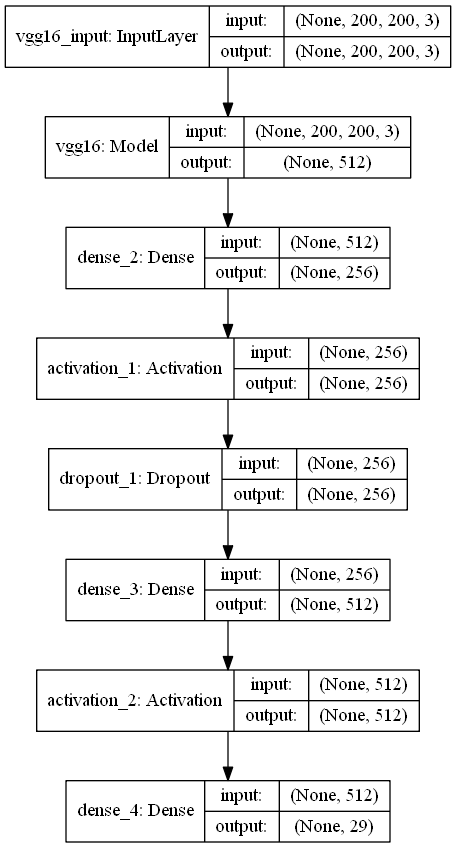

In [14]:
# Saving the model summary as an image
plot_model(model, to_file='vgg16_asl.png', 
show_shapes=True, show_layer_names=True)                          

Image augmentation was configured using the following [resource](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/). 

Images were augmented in the hopes of improving the VGG16 model's ability to classify new ASL alphabet images (e.g., real-time webcam images). 

In [15]:
# Istantiating the training/validation ImageDataGenerator()
datagen_train = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True, 
                                   width_shift_range=[-5,5],
                                   zoom_range=0.1,
                                   shear_range=0.1,
                                   brightness_range=[0.9,1.2],
                                   fill_mode='reflect',
                                   validation_split=0.1)

# Istantiating the test generator
datagen_test = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True, 
                                   width_shift_range=[-5,5],
                                   zoom_range=0.1,
                                   shear_range=0.1,
                                   brightness_range=[0.9,1.2],
                                   fill_mode='reflect')

In [16]:
# The generator for the training data, shuffle set to True 
# (unable to view confusion matrix and classification report as a result)
train_generator = datagen_train.flow_from_directory(path+'training_set/',
                                                    target_size=(pixels, pixels),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True, subset='training')

# Generator for validation data, shuffle set to 'False' to allow for model evaluation
validation_generator = datagen_train.flow_from_directory(path+'training_set/',
                                                    target_size=(pixels, pixels),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False, subset='validation')

# Generator for test data, shuffle set to 'False' to allow for model evaluation
test_generator = datagen_test.flow_from_directory(path+'test_set/',
                                                    target_size=(pixels, pixels),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 62640 images belonging to 29 classes.
Found 6960 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.


In [17]:
# Saving the number of stepsizes for the training, validation and test sets 
train_stepsize = train_generator.n//train_generator.batch_size
valid_stepsize = validation_generator.samples//validation_generator.batch_size
test_stepsize = test_generator.samples//test_generator.batch_size

# Sanity check 
print(f'Training step size = {train_stepsize}, Validation step size = {valid_stepsize}')
print(f'Test step size = {test_stepsize}')

Training step size = 1566, Validation step size = 174
Test step size = 435


Finally, we will utilize `keras.callbacks`: 

- `EarlyStopping()` to [prevent overfitting](https://machinelearningmastery.com/early-stopping-to-avoid-overtraining-neural-network-models/) to the training images, and 


- `ModelCheckpoint()` to [save the best model weights](https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/) based on loss achieved on the validation dataset, which may not coincide with the model at the end of training.  



In [18]:
# Initiate early stop based on validation loss
# Will not stop before 'min_epochs' of 12 (patience)
ES = EarlyStopping(monitor='val_loss', mode='min', min_delta=0, patience=min_epochs, verbose=1)

# Model checkpointer that will only save the weights from the epoch with the best validation loss
checkpoint = ModelCheckpoint("best_weights_vgg16.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')


# Adding both callbacks to a 'callbacks_list'
callbacks_list = [ES, checkpoint]    

Now, we will train the model on the training ASL images. 

The model's progress will be saved to the variable `history` to allow for visualization of the progression of train and validation accuracies and losses.  

In [19]:
# Fitting the model to the training data
history = model.fit_generator(generator=train_generator,
                                steps_per_epoch=train_stepsize,
                                epochs=epochs,
                                validation_data=validation_generator,
                                validation_steps=valid_stepsize,
                                callbacks=callbacks_list)

Epoch 1/30
1566/1566 [==============================] - 1093s 698ms/step - loss: 0.2869 - accuracy: 0.9135 - val_loss: 2.3542e-04 - val_accuracy: 0.9658

Epoch 00001: val_loss improved from inf to 0.00024, saving model to best_weights_vgg16.h5
Epoch 2/30
1566/1566 [==============================] - 738s 471ms/step - loss: 0.0344 - accuracy: 0.9901 - val_loss: 1.5706e-06 - val_accuracy: 0.9822

Epoch 00002: val_loss improved from 0.00024 to 0.00000, saving model to best_weights_vgg16.h5
Epoch 3/30
1566/1566 [==============================] - 739s 472ms/step - loss: 0.0193 - accuracy: 0.9945 - val_loss: 4.4701e-06 - val_accuracy: 0.9829

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/30
1566/1566 [==============================] - 739s 472ms/step - loss: 0.0189 - accuracy: 0.9949 - val_loss: 4.1723e-08 - val_accuracy: 0.9886

Epoch 00004: val_loss improved from 0.00000 to 0.00000, saving model to best_weights_vgg16.h5
Epoch 5/30
1566/1566 [==============================] - 73

Visualizing the model's training and validation loss and accuracy progression for every epoch. 

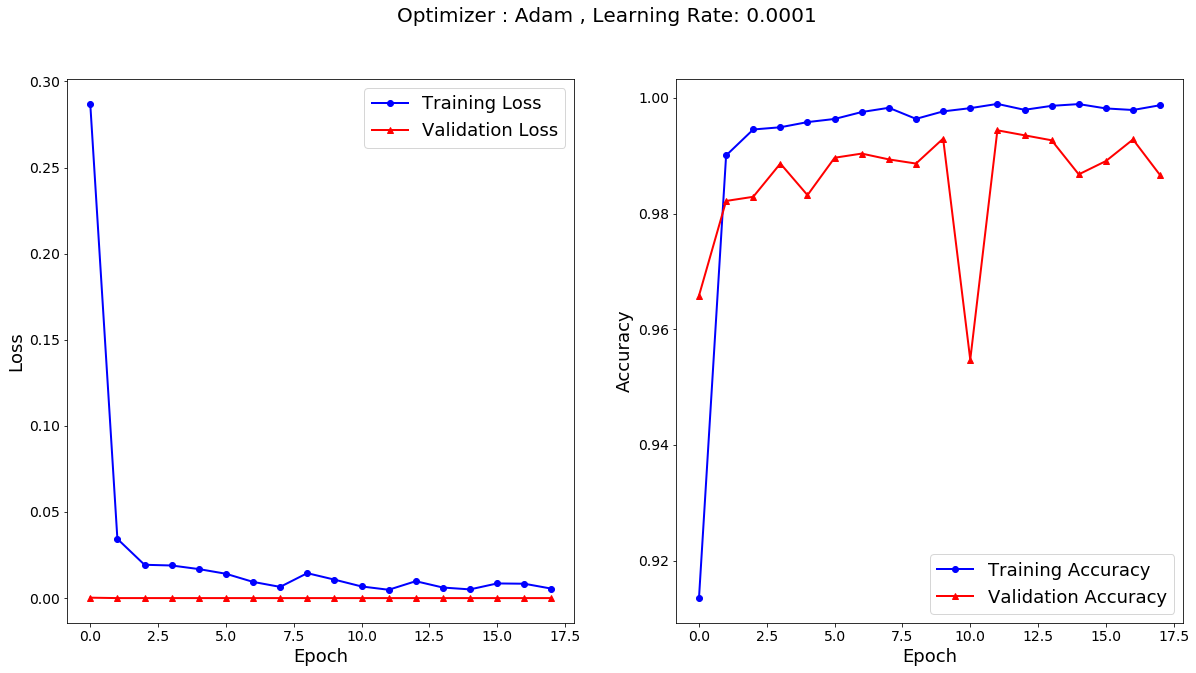

In [20]:
# Initializing the subplot 
plt.subplots(1,2,figsize=(20,10))

# Plotting the model's training and validation loss progression for every completed epoch 
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2, marker='o', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, marker='^', color='red')

# Formatting axes and titles
plt.suptitle('Optimizer : Adam , Learning Rate: 0.0001', fontsize=20)
plt.ylabel('Loss', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Formatting legend
plt.legend(loc='upper right', fontsize=18)

# Plotting the training and validation accuracy changes for every epoch 
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, marker='o', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, marker='^', color='red')

# Formatting axes and titles
plt.ylabel('Accuracy', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

# Formatting legend
plt.legend(loc='lower right', fontsize=18)

# Display the plots
plt.show()

## Model Evaluation 

In order to evaluate the `bestmodel`'s performance we will need to load in the `best_weights_vgg16.h5` saved by `ModelCheckpoint()`. 

In [21]:
# Saving the CNN architecture as a JSON
modelarch_json = model.to_json()
with open("VGG16_all.json","w") as json_file:
    json_file.write(modelarch_json)
    
# Initialize the 'bestmodel' using the weights saved with the ModelCheckpoint callback
bestmodel = model_from_json(modelarch_json)

# Loading the weights that resulted in the best validation accuracy during training 
bestmodel.load_weights("best_weights_vgg16.h5")

# Compile the bestmodel
bestmodel.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

The `bestmodel` that resulted from training will be evaluated via classification reports and confusion matrices normalized by the number of images for the given class. 

In [22]:
# Creating axis labels for future sns.heatmaps 

# Getting the class names
categories = list(train_generator.class_indices.keys())

# Preficing classes with 'Predicted ' 
predicted_labels = list('Predicted '  + category for category in categories)

# Preficing classes with 'True '
true_labels = list('True ' + category for category in categories)

# Creating labels(indices) for model evaluation metrics 
eval_metrics = list(bestmodel.metrics_names)

**NOTE:** Unable to create a classification report or confusion matrix for train data as train_generator(shuffle=True) does not save the shuffled order of the true classes. 

In [23]:
# Re-evaluating the best model's performance on the training data
train_eval = bestmodel.evaluate_generator(train_generator, steps=train_stepsize)

# Saving the results to a dataframe
df_train_eval = pd.DataFrame(list(train_eval), index=eval_metrics, columns=['Train'])

# Display the results
print(df_train_eval)

             Train
loss      0.000015
accuracy  0.999298


Thus, `bestmodel` achieved 99.9% accuracy and < 0.0001 categorical crossentropy loss on the train dataset. 

-----

### Evaluating `bestmodel` Performance on the Validation Dataset

First, we will acquire the model's predictions and saving to variable `valid_predictions`. 

In [24]:
# Getting bestmodel's predictions (as probabilities) on the validation images 
validation_probas = bestmodel.predict_generator(validation_generator, steps=valid_stepsize)

# Setting the model's class prediction as the class that received the highest probability for each image
valid_predictions = validation_probas.argmax(axis=1)

# Sanity check 
valid_predictions

array([ 0,  0,  0, ..., 28, 28, 28], dtype=int64)

Next, acquiring the images' true labels and saving to variable `valid_true`. 

In [25]:
# Getting the true class labels for the validation data
valid_true = validation_generator.classes

# Sanity check 
valid_true

array([ 0,  0,  0, ..., 28, 28, 28])

Finally, we will compare `valid_predictions` with `valid_true` to acquire model accuracy, precision, recall, f1-scores and a confusion matrix. 

In [26]:
# Evaluating bestmodel's performance on the validation data 
valid_eval = bestmodel.evaluate_generator(validation_generator, steps=valid_stepsize)

# Saving the results to a dataframe
df_valid_eval = pd.DataFrame(list(valid_eval), index=eval_metrics, columns=['Validation'])

# Display the results 
print(df_valid_eval)

          Validation
loss        0.000000
accuracy    0.989799


Thus, `bestmodel` achieved 99.0% accuracy and < 0.00001 categorical crossentropy loss on the validation dataset.

In [27]:
# Displaying the classification report for the validation set
print('Validation Classification Report\n \n', classification_report(valid_true, valid_predictions, target_names=categories))

Validation Classification Report
 
               precision    recall  f1-score   support

           A       0.92      1.00      0.96       240
           B       1.00      1.00      1.00       240
           C       1.00      1.00      1.00       240
           D       1.00      1.00      1.00       240
           E       0.99      1.00      0.99       240
           F       1.00      1.00      1.00       240
           G       1.00      0.97      0.99       240
           H       1.00      1.00      1.00       240
           I       1.00      0.99      0.99       240
           J       1.00      1.00      1.00       240
           K       0.97      1.00      0.98       240
           L       1.00      1.00      1.00       240
           M       0.96      1.00      0.98       240
           N       1.00      0.95      0.98       240
           O       1.00      1.00      1.00       240
           P       1.00      1.00      1.00       240
           Q       1.00      0.98      0.99  

The model achieved high precision, recall and f1-scores, which ranged from <b>93 - 100 %</b> when predicting on the validation set. 

The metrics in the classifcation report aligned with `bestmodel`'s accuracy score, which can be expected given the balanced number of images in each class. 

In [28]:
# Creating a non-normalized confusion matrix for the validation set
valid_matrix = pd.DataFrame(confusion_matrix(valid_true, valid_predictions), columns=predicted_labels, index=true_labels)

# Display the matrix
valid_matrix

,Predicted A,Predicted B,Predicted C,Predicted D,Predicted E,Predicted F,Predicted G,Predicted H,Predicted I,Predicted J,...,Predicted T,Predicted U,Predicted V,Predicted W,Predicted X,Predicted Y,Predicted Z,Predicted del,Predicted nothing,Predicted space
True A,240,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
True B,0,240,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
True C,0,0,240,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
True D,0,0,0,240,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
True E,0,1,0,0,239,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
True F,0,0,0,0,0,239,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
True G,0,0,0,0,0,0,234,0,0,0,...,0,0,0,0,0,0,0,0,0,0
True H,0,0,0,0,0,0,0,240,0,0,...,0,0,0,0,0,0,0,0,0,0
True I,0,0,0,0,3,0,0,0,237,0,...,0,0,0,0,0,0,0,0,0,0
True J,0,0,0,0,0,0,0,0,0,240,...,0,0,0,0,0,0,0,0,0,0


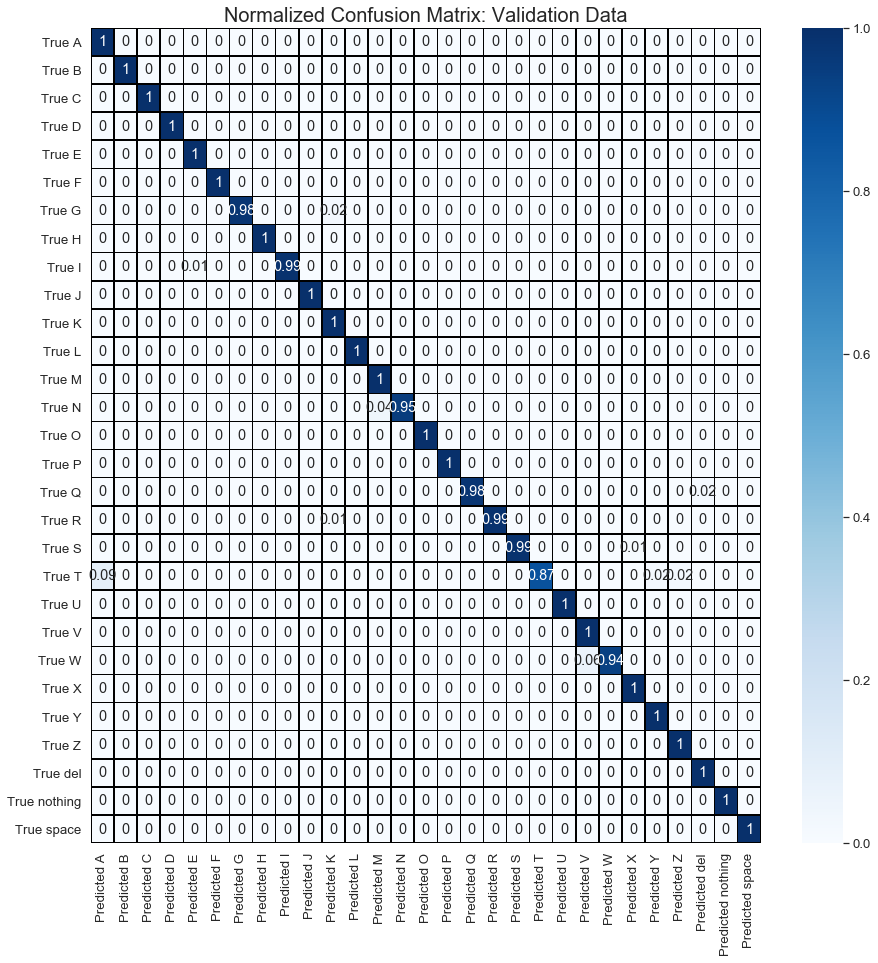

In [29]:
# Plotting the normalized confusion matrix (proportion of predictions by class) as a heatmap

# Increasing fontsize
sns.set(font_scale=1.2)

# Creating the plot
plt.figure(figsize=(15,15))
sns.heatmap(round(valid_matrix/valid_matrix.sum(axis=1)[:,np.newaxis],2), cmap='Blues', annot=True, linewidths=.5, linecolor='black')

# Formatting the title 
plt.title('Normalized Confusion Matrix: Validation Data', fontsize=20)

# Display the normalized confusion matrix
plt.show()

Based on the non-normalized and normalized confusion matrices, `bestmodel` proved successful at predicting the classes of the validation set. 

-----

### Evaluating `bestmodel` Performance on the Test Dataset

Similar as above, we will first acquire the model's predictions and saving to variable `test_predictions`. 

In [30]:
# Getting bestmodel's predictions (as probabilities) on the test set 
test_probas = bestmodel.predict_generator(test_generator, steps=test_stepsize)

# Setting the model's class prediction as the class that received the highest probability for each image
test_predictions = test_probas.argmax(axis=1)

# Sanity check 
test_predictions

array([ 0,  0,  0, ..., 28, 28, 28], dtype=int64)

Next, saving the true classes of the test images to the variable `test_true`. 

In [31]:
# Getting the true class labels for the test set
test_true = test_generator.classes

# Sanity check 
test_true

array([ 0,  0,  0, ..., 28, 28, 28])

Finally, we will compare `test_predictions` with `test_true` to acquire model accuracy, precision, recall, f1-scores and confusion matrices to evalute model performance on the test set. 

In [32]:
# Evaluating the best model's performance on the test data 
test_eval = bestmodel.evaluate_generator(test_generator, steps=test_stepsize)

# Saving the results to a dataframe 
df_test_eval = pd.DataFrame(list(test_eval), index=eval_metrics, columns=['Test'])

# Display the results
print(df_test_eval)

                  Test
loss      8.940696e-09
accuracy  9.980460e-01


`bestmodel` achieved 99.8% accuracy and < 0.00001 categorical crossentropy loss on the test set.

In [33]:
# Displaying the classification report for the test set
print('Test Classification Report\n \n', classification_report(test_true, test_predictions, target_names=categories))

Test Classification Report
 
               precision    recall  f1-score   support

           A       0.99      1.00      1.00       600
           B       1.00      1.00      1.00       600
           C       1.00      1.00      1.00       600
           D       1.00      1.00      1.00       600
           E       1.00      1.00      1.00       600
           F       1.00      1.00      1.00       600
           G       1.00      0.99      1.00       600
           H       1.00      1.00      1.00       600
           I       1.00      0.99      1.00       600
           J       0.99      1.00      1.00       600
           K       0.99      1.00      1.00       600
           L       1.00      1.00      1.00       600
           M       0.99      1.00      0.99       600
           N       1.00      0.99      0.99       600
           O       1.00      1.00      1.00       600
           P       1.00      1.00      1.00       600
           Q       1.00      1.00      1.00       6

`bestmodel` also achieved great precision, recall and f1-scores, which ranged from 99 - 100 %. 

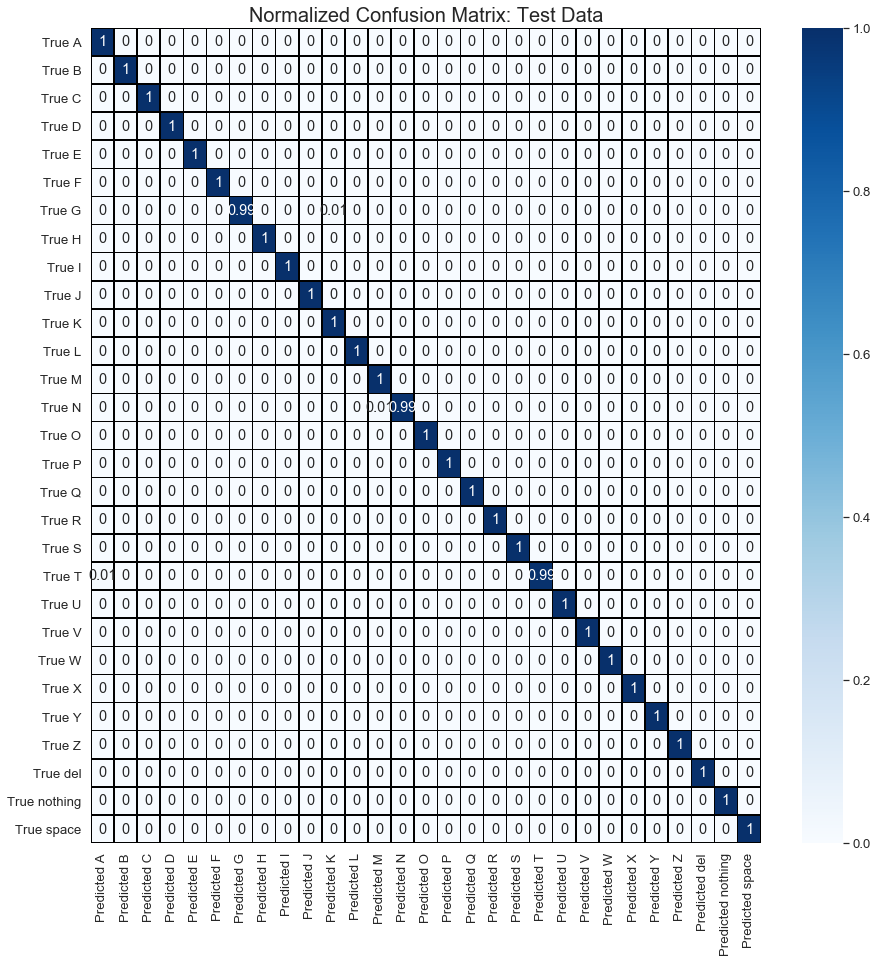

In [34]:
# Non-normalized confusion matrix for the test data
test_matrix = pd.DataFrame(confusion_matrix(test_true, test_predictions), columns=predicted_labels, index=true_labels)

# Plotting a normalized confusion matrix for the test data as a heatmap 
sns.set(font_scale=1.2)
plt.figure(figsize=(15,15))
sns.heatmap(round(test_matrix/test_matrix.sum(axis=1)[:,np.newaxis],2), cmap='Blues', annot=True, linewidths=.5, linecolor='black')
plt.title('Normalized Confusion Matrix: Test Data', fontsize=20)
plt.show()

Based on the non-normalized and normalized confusion matrices, `bestmodel` proved successful at predicting the classes of images it had never seen before (i.e., test set images). 

However, the test images were very similar to the images that the VGG16 CNN was trained on, which may account for the high evaluation metrics seen across the validation and test sets. 

-----

Keeping in mind that the final goal is to classify letters of the ASL alphabet from new images taken in real-time, the `best_weights_vgg16.h5` obtained from the training of VGG16 in this notebook will undergo additional evaluation of: 

**Predicting on images taken from live webcam in the subsequent notebook** `real-time_test.ipynb`. 